In [1]:
import scipy.io
from scipy import signal
from scipy.stats import norm
from scipy.stats import skew
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


In [2]:
directory = "C:\\Users\\grazi\\Desktop\\Materiale FVAB\\SEED_IV Database\\SEED_IV Database"
#directory = "D:\\DATASET FVAB\\SEED_IV Database\\SEED_IV Database\\"

In [3]:
directory

'C:\\Users\\grazi\\Desktop\\Materiale FVAB\\SEED_IV Database\\SEED_IV Database'

# Original code

In [4]:
path = os.path.join(directory, "eeg_raw_data", "1", "10_20151014.mat")

In [5]:
data = scipy.io.loadmat(path)

In [6]:
#Prende tutti gli header per estrarre i dati
labels = list(data.keys())
size = len(labels)

In [7]:
# Carica il dataset in un dataframe di pandas usando gli header
for i in range(3,size,1):
    df = pd.DataFrame(data[labels[i]])
    print(df.shape)
    #df.transpose()
    #df.to_csv(labels[i]+".csv")

(62, 33601)
(62, 19001)
(62, 39801)
(62, 26001)
(62, 17601)
(62, 32401)
(62, 30601)
(62, 41801)
(62, 29001)
(62, 33801)
(62, 10001)
(62, 22001)
(62, 43401)
(62, 33801)
(62, 51801)
(62, 28201)
(62, 13601)
(62, 35801)
(62, 28001)
(62, 9601)
(62, 22401)
(62, 22401)
(62, 35001)
(62, 27401)


In [8]:
channel_order = pd.read_excel(os.path.join(directory,"Channel Order.xlsx"), header=None)

In [9]:
session1_label = [1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3]
session2_label = [2,1,3,0,0,2,0,2,3,3,2,3,2,0,1,1,2,1,0,3,0,1,3,1]
session3_label = [1,2,2,1,3,3,3,1,1,2,1,0,2,3,3,0,2,3,0,0,2,0,1,0]
labels = session1_label + session2_label + session3_label

In [10]:
directory = os.path.join(directory, 'eeg_raw_data')

## WIP (Merge Dataset x sessioni e utenti)

In [11]:
df_global = pd.DataFrame()

In [12]:
pd.concat([df_global,df])

,0,1,2,3,4,5,6,7,8,9,...,27391,27392,27393,27394,27395,27396,27397,27398,27399,27400
0,-7.033348,-7.748604,-10.460615,-11.682510,-11.801720,-6.258488,-7.301569,-5.692244,-3.546476,-4.202127,...,-4.142523,0.774860,1.072884,-1.221895,-5.424023,-1.043081,-6.943941,-2.026558,-10.728836,-7.867813
1,-1.013279,-1.847744,-1.788139,-3.904104,-6.556511,-1.549721,-0.447035,1.341105,0.029802,4.351139,...,0.208616,5.453825,2.175570,3.695488,0.983477,-0.357628,-2.771616,1.281500,-8.463860,-1.043081
2,-2.354383,-1.907349,-1.251698,-3.725290,-5.990267,-0.685453,0.596046,1.072884,-1.281500,4.351139,...,-6.794930,-4.917383,-9.566545,-4.142523,-7.688999,-7.897615,-11.920929,-10.371208,-17.672777,-12.606382
3,2.503395,-3.248453,1.549721,-2.533197,2.145767,-2.264977,1.847744,-4.023314,1.341105,-1.311302,...,0.536442,-2.801418,0.298023,-2.145767,1.251698,-1.192093,0.417233,-0.298023,-1.251698,-0.506639
4,-0.089407,1.072884,0.506639,-2.652407,-4.261732,0.029802,2.384186,2.175570,1.549721,5.364418,...,1.966953,2.771616,-2.145767,1.460314,-1.817942,0.298023,-4.082918,0.327826,-8.404255,-3.069639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,8.285046,5.125999,9.298325,2.533197,13.262033,6.705523,7.987022,5.304813,0.685453,14.573336,...,11.801720,11.414289,5.930662,6.407499,4.202127,-3.069639,-1.758337,-4.231930,-7.510185,-5.602837
58,-6.020069,-10.281801,-6.765127,-27.477741,6.943941,-6.973743,-8.046627,-11.414289,-17.374754,0.745058,...,17.344952,19.520521,5.245209,16.003847,9.089708,7.480383,8.881092,5.900860,-1.996756,7.659197
59,1.519918,0.834465,1.490116,-5.275011,6.079674,2.413988,1.937151,0.119209,-2.175570,8.374453,...,14.364719,13.351440,8.076429,11.473894,8.791685,4.053116,5.185604,3.993511,1.519918,3.546476
60,2.682209,2.205372,1.788139,1.251698,2.503395,5.304813,4.291534,6.556511,2.324581,8.195639,...,-1.311302,-3.278255,-7.510185,-4.172325,-6.645918,-8.761883,-11.056662,-10.699034,-10.073185,-7.301569


# Drop channels

In [11]:
def drop_channels(df):
    df = df.set_index(channel_order[0])
    df = df.transpose()
    df = df[['FT7','FT8','T7', 'T8', 'TP7', 'TP8']]
    df = df.transpose()
    return df

In [12]:
df_6_channels = drop_channels(pd.DataFrame(data['tyc_eeg1']))

In [13]:
df_6_channels.index.names = ['Channels']

In [14]:
print(df_6_channels.shape)

(6, 33601)


# Downsampling e filtering

In [18]:
def down_sampling(data):
    sfreq = 1000
    new_sfreq = 200
    
    data = signal.resample(data, int(len(data) * new_sfreq / sfreq))    
    return data

In [19]:
def band_pass_filter(data):
    sfreq = 1000
    nyquist_frequency = sfreq / 2
    lowcut = 0.3 
    highcut = 50
    order = 4
       
    b, a = signal.butter(order, [lowcut/nyquist_frequency, highcut/nyquist_frequency], btype='band')
    data = signal.filtfilt(b, a, data, padlen=0)
    return data

<AxesSubplot: >

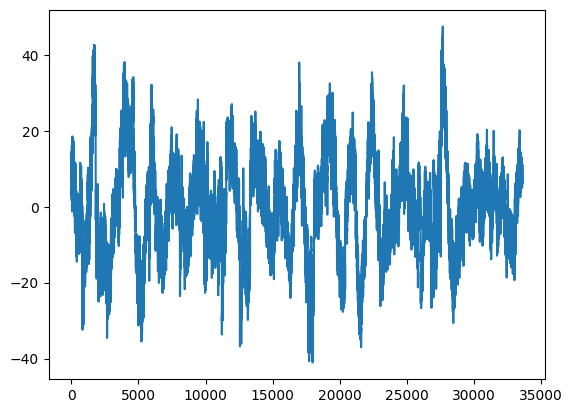

In [27]:
df_6_channels.iloc[3].plot()

In [20]:
processed_data_down = down_sampling(df_6_channels.T)

In [21]:
print(processed_data_down.shape)

(6720, 6)


<AxesSubplot: >

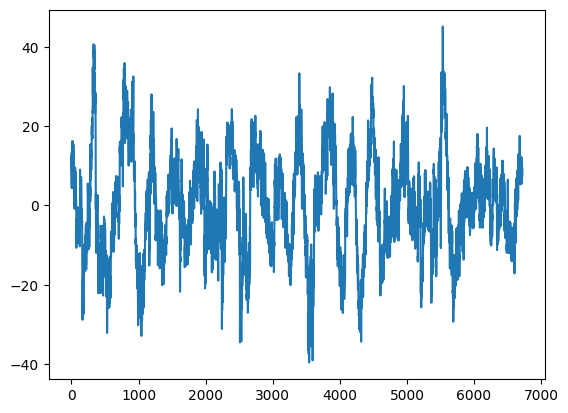

In [33]:
pd.DataFrame(processed_data_down)[3].plot()

In [23]:
processed_data_filter = band_pass_filter(processed_data_down)

In [24]:
print(processed_data_filter.shape)

(6720, 6)


<AxesSubplot: >

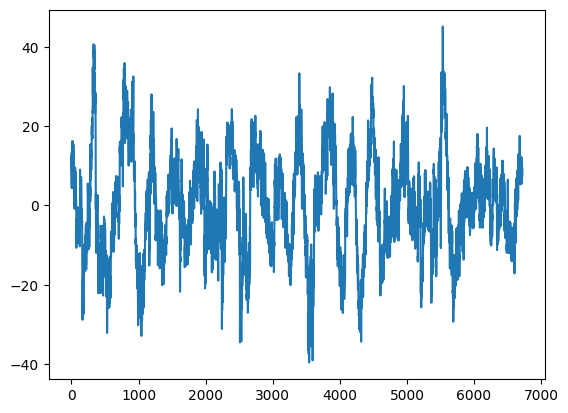

In [28]:
pd.DataFrame(processed_data_down)[3].plot()

In [30]:
filtered_dataset = pd.DataFrame(processed_data_filter).T

In [38]:
filtered_dataset['Channels'] = ['FT7','FT8','T7', 'T8', 'TP7', 'TP8']

In [40]:
filtered_dataset.set_index('Channels',inplace=True)

## Feature Extraction

### PSD

In [44]:
# Imposta le bande di frequenza
frequencies_delta = np.arange(1, 4)
frequencies_theta = np.arange(4, 8)
frequencies_alpha = np.arange(8, 14)
frequencies_beta = np.arange(14, 31)
frequencies_gamma = np.arange(31, 50)

# Calcola la PSD utilizzando la funzione welch
#f, psd = signal.welch(processed_data_filter.T, 50 , nperseg=4000)
f, psd = signal.welch(filtered_dataset, 50 , nperseg=4000)
print(psd.shape)

# Seleziona solo le frequenze specificate
#freq_indices = np.searchsorted(f, frequencies)
#frequencies_selected = f[freq_indices]
#psd_selected = psd[freq_indices]
#f, Pxx_den = signal.welch(preprocessed_data_filter, fs, nperseg=1024)

(6, 2001)


In [48]:
psd

array([[6.21179445e-05, 5.13636629e-05, 2.31925491e-04, ...,
        3.32974636e-06, 3.16733467e-06, 1.54833864e-06],
       [1.19408947e-05, 9.83223849e-06, 4.48803335e-05, ...,
        6.42627019e-07, 6.12990550e-07, 3.00117164e-07],
       [1.37300247e-06, 1.12667846e-06, 5.20172355e-06, ...,
        7.42857244e-08, 7.10853845e-08, 3.48579214e-08],
       [7.22409721e-08, 5.91415187e-08, 2.76117427e-07, ...,
        3.93370144e-09, 3.77699282e-09, 1.85492712e-09],
       [9.55780181e-10, 7.81821462e-10, 3.68461208e-09, ...,
        5.23936381e-11, 5.04639680e-11, 2.48160463e-11],
       [1.13893063e-13, 9.82599877e-14, 4.14959916e-13, ...,
        6.07479432e-15, 5.70294233e-15, 2.75842719e-15]])

### DE

In [45]:
entropy = scipy.stats.differential_entropy(filtered_dataset)
print(entropy)

[-3.31875362 -3.31569006 -3.00140954 ... -4.06612605 -4.10846043
 -4.95444633]


## ASM

In [47]:
left_hemisphere = ['FT7','T7', 'TP7']
right_hemisphere = ['FT8','T8','TP8']

logicaland tra i due emisferi (risultato psd f)
band_power media tra psd 
asymmetry_scores[i, j] = (np.sum(band_power[channel_mask]) -
                                  np.sum(band_power[~channel_mask])) / np.sum(band_power)
total_power[i, j] = np.sum(band_power)

In [46]:
asymmetry = skew(filtered_dataset)
print(asymmetry)

[1.20701063 1.20953472 1.21088051 ... 1.1931527  1.18870425 1.17135375]


In [ ]:
# Define frequency bands of interest
freq_bands = {'alpha': [8, 13]}

# Define electrode groups for left and right hemispheres
left_hemisphere = ['F3', 'F7', 'C3', 'T7', 'P3', 'O1']
right_hemisphere = ['F4', 'F8', 'C4', 'T8', 'P4', 'O2']

# Initialize arrays to store asymmetry scores and total power
asymmetry_scores = np.zeros((len(freq_bands), 2))
total_power = np.zeros((len(freq_bands), 2))

# Compute power spectral densities for each channel using Welch's method
for i, (band_name, freq_range) in enumerate(freq_bands.items()):
    freq_mask = (sfreq / 2) * np.array(freq_range)
    for j, hemisphere in enumerate([left_hemisphere, right_hemisphere]):
        channel_mask = np.isin(channel_names, hemisphere)
        channel_data = eeg_data[channel_mask, :]
        freqs, psds = welch(channel_data, sfreq, nperseg=1024, axis=-1, average='mean')
        freq_masked = np.logical_and(freqs >= freq_mask[0], freqs <= freq_mask[1])
        band_power = np.mean(psds[:, freq_masked], axis=1)
        asymmetry_scores[i, j] = (np.sum(band_power[channel_mask]) -
                                  np.sum(band_power[~channel_mask])) / np.sum(band_power)
        total_power[i, j] = np.sum(band_power)


## DASM

In [ ]:
F3_idx = np.where(f == 3)[0][0]
F4_idx = np.where(f == 4)[0][0]
dasm = np.abs(psd[:, F3_idx, :] - psd[:, F4_idx, :]) / (psd[:, F3_idx, :] + psd[:, F4_idx, :])

# Script

In [31]:
if os.path.exists(directory):
    lista_cartella_main = os.listdir(directory)
    for file in lista_cartella_main:
        sec = os.path.join(directory, file)
        if os.path.isdir(sec):
            files1 = os.listdir(sec)
            for file1 in files1:
                if file1.endswith(".mat"):
                    file1 = os.path.join(sec, file1)
                    data = scipy.io.loadmat(file1)
                    labels = list(data.keys())
                    size = len(labels)
                    print(file1)
                    for i in range(3,size,1):
                        df = pd.DataFrame(data[labels[i]])
                        df = drop_channels(df)
                        downsampled = down_sampling(data[labels[i]])
                        filtered = band_pass_filter(downsampled)
                        df = pd.DataFrame(filtered)
                        print(df.shape)

C:\Users\grazi\Desktop\Materiale FVAB\SEED_IV Database\SEED_IV Database\eeg_raw_data\1\10_20151014.mat
(12, 33601)
(12, 19001)
(12, 39801)
(12, 26001)
(12, 17601)
(12, 32401)
(12, 30601)
(12, 41801)
(12, 29001)
(12, 33801)
(12, 10001)
(12, 22001)
(12, 43401)
(12, 33801)
(12, 51801)
(12, 28201)
(12, 13601)
(12, 35801)
(12, 28001)
(12, 9601)
(12, 22401)
(12, 22401)
(12, 35001)
(12, 27401)
C:\Users\grazi\Desktop\Materiale FVAB\SEED_IV Database\SEED_IV Database\eeg_raw_data\1\11_20150916.mat
(12, 33601)
(12, 19001)
(12, 39801)
(12, 26001)
(12, 17601)
(12, 32401)
(12, 30601)
(12, 41801)
(12, 29001)
(12, 33801)
(12, 10001)
(12, 22001)
(12, 43401)
(12, 33801)
(12, 51801)
(12, 28201)
(12, 13601)
(12, 35801)
(12, 28001)
(12, 9601)
(12, 22401)
(12, 22401)
(12, 35001)
(12, 27401)


KeyboardInterrupt: 